# Implementation of Double Q Learning
# http://papers.nips.cc/paper/3964-double-q-learning.pdf

In [164]:
import numpy as np
import random
import gym

In [165]:
from numpy import tanh
from scipy.special import softmax
import pdb
from collections import deque

In [166]:
class DQNNModel(object):
    '''
    Two layer neural net
    input X
    Z1 = dot(X, W1) + B1
    Z2 = tanh(Z1)
    Z3 = dot(Z2, W2) + B2
    y_hat = Z3
    
    Loss(L) = 0.5 * (y_hat - y)**2
    
    dL/dy_hat = y_hat-y
    dy_hat/dZ3 = y_hat-y
    dZ3/dW2 = Z2
    dZ3/dB2 = 1
    dZ3/dZ2 = W2
    dZ2/dZ1 = 1 - Z2^2
    dZ1/dW1 = X
    dZ1/dB1 = 1
    
    Using chain rule
    
    dL/dW2 = (y_hat-y)*Z2
    dL/dB2 = (y_hat-y)
    
    dL/dW1 = (y_hat-y)*W2*(1-Z2^2)*X
    (input,hidden) = (1,output)*(hidden,output)*(1,hidden)*(1,input)
    
    dL/dB1 = (y_hat-y)*W2*(1-Z2^2)
    
    
    '''
    def __init__(self, ninput, nhidden, noutput):
        self.ninput_ = ninput
        self.nhidden_ = nhidden
        self.noutput_ = noutput
        #initialize model weights
        #X=(1,input)
        self.W1_ = np.random.randn(ninput, nhidden) / np.sqrt(nhidden)
        self.B1_ = np.random.randn(1, nhidden) / np.sqrt(nhidden)
        self.W2_ = np.random.randn(nhidden, noutput) / np.sqrt(noutput)
        self.B2_ = np.random.randn(1, noutput) / np.sqrt(noutput)
        
        self.dW1_cache_ = 0.
        self.dB1_cache_ = 0.
        self.dW2_cache_ = 0.
        self.dB2_cache_ = 0.
    
    def __str__(self):
        return_str = ""
        for i,j in self.__dict__.items():
            return_str += str(i) + " " + str(j) + "\n"  
        return return_str
    
    def forward(self, x):
        #x=(1,input)
        #W1=(input,hidden)
        z1 = np.dot(x, self.W1_) + self.B1_ #(1,hidden)
        z2 = tanh(z1) #(1,hidden)
        z3 = np.dot(z2, self.W2_) + self.B2_ #(1,output)
        #W2=(hidden, output)
        y_hat = z3 #(1,output)
        return y_hat, z1, z2, z3, self.W1_, self.W2_
    
    def loss(self, y, y_hat):
        loss = 0.5 * (y_hat - y)**2
        return loss
    
    def backward(self, x, y, y_hat, z1, z2, z3, w1, w2, clip=True):
        #pdb.set_trace()
        dlogp = y_hat-y
        if(clip):
            np.clip(dlogp, -1, 1, out=dlogp)
        
        dB2 = dlogp # (1, output)
        dW2 = np.dot(z2.T, dlogp) #(hidden, output)
        
        dB1 = np.dot(dlogp, w2.T)*(1-(z2*z2)) #(1,hidden)
        dW1 = np.dot(x.T, dB1) #(input,hidden)
        return dW1, dB1, dW2, dB2
            
    
    def update_SGD(self, dW1, dB1, dW2, dB2, lr=1e-4):
        self.W1_ -= lr*dW1
        self.B1_ -= lr*dB1
        self.W2_ -= lr*dW2
        self.B2_ -= lr*dB2
        
    def get_weights(self):
        return self.W1_, self.B1_, self.W2_, self.B2_
    
    def put_weights(self, W1, B1, W2, B2):
        self.W1_ = W1
        self.B1_ = B1
        self.W2_ = W2
        self.B2_ = B2
    
    def put_from_model(self, model):
        self.W1_ = model.W1_
        self.B1_ = model.B1_
        self.W2_ = model.W2_
        self.B2_ = model.B2_

        
    def update_RMSProp(self, dW1, dB1, dW2, dB2, lr=1e-4):
        decay_rate = 0.9
        eps = 1e-4
        
        self.dW1_cache_ = decay_rate * self.dW1_cache_ + (1 - decay_rate) * (dW1)**2
        self.W1_ += - lr * dW1 / (np.sqrt(self.dW1_cache_) + eps)

        self.dW2_cache_ = decay_rate * self.dW2_cache_ + (1 - decay_rate) * (dW2)**2
        self.W2_ += - lr * dW2 / (np.sqrt(self.dW2_cache_) + eps)

        self.dB1_cache_ = decay_rate * self.dB1_cache_ + (1 - decay_rate) * (dB1)**2
        self.B1_ += - lr * dB1 / (np.sqrt(self.dB1_cache_) + eps)

        self.dB2_cache_ = decay_rate * self.dB2_cache_ + (1 - decay_rate) * (dB2)**2
        self.B2_ += - lr * dB2 / (np.sqrt(self.dB2_cache_) + eps)        
                

In [167]:
env_name = 'CartPole-v1'
env = gym.make(env_name)

In [168]:
state = env.reset()
INPUT_UNITS = state.shape[0]
HIDDEN_UNITS = 100
OUTPUT_UNITS = env.action_space.n
model_a = DQNNModel(INPUT_UNITS, HIDDEN_UNITS, OUTPUT_UNITS)
model_b = DQNNModel(INPUT_UNITS, HIDDEN_UNITS, OUTPUT_UNITS)


In [169]:
num_episodes = 5000

display_after = 100
display_after_counter = 0

episode_steps_rs = []
episode_loss_rs = []


for episode in range(num_episodes):
    episode_steps = 0
    episode_loss = 0
    
    while True:
        state = state.reshape(1,-1)

        y_hat_a, _, _, _, _, _ = model_a.forward(state)
        action_a = np.argmax(y_hat_a[0])
        
        y_hat_b, _, _, _, _, _ = model_b.forward(state)
        action_b = np.argmax(y_hat_b[0])
        
        action = action_a if random.random()>0.5 else action_b
        
        new_state, reward, done, info = env.step(action)
        
        update_a = 1 if random.random()>0.5 else 0
        
        new_state = new_state.reshape(1,-1)
        target = np.zeros((1,env.action_space.n))
        if done:
            target[0][action] = reward
        else:
            target_model = model_b if update_a else model_a
            model = model_a if update_a else model_b

            t_val,_,_,_,_,_ = target_model.forward(new_state)
            target[0][action] = reward
            target += 0.99 * (t_val)


        y_hat, z1, z2, z3, w1, w2 = model.forward(state)
        y = target
        dw1, db1, dw2, db2 = model.backward(state, y, y_hat, z1, z2, z3, w1, w2, clip=False)

        #model.update_SGD(dw1, db1, dw2, db2)
        model.update_RMSProp(dw1, db1, dw2, db2)
        episode_loss += model.loss(y, y_hat).mean()

        state = new_state
        episode_steps += 1
        
        #pdb.set_trace()

        if done:
            display_after_counter += 1
            average_episode_loss = episode_loss / episode_steps                         
            episode_loss_rs.append(average_episode_loss)
            state = env.reset()
            episode_steps_rs.append(episode_steps)

            if (display_after_counter%display_after == 0):
                episode_steps_buffer = episode_steps_rs[-display_after:]
                episode_loss_buffer = episode_loss_rs[-display_after:]
                #print(episode_loss_buffer)
                min_steps = np.min(episode_steps_buffer)
                max_steps = np.max(episode_steps_buffer)
                avg_steps = np.mean(episode_steps_buffer)
                print("Episode %d, max %d, min %d, avg %d steps, avg loss %f"%(episode+1,max_steps,min_steps, avg_steps, np.mean(episode_loss_buffer)))

            
            break
            

Episode 100, max 15, min 8, avg 11 steps, avg loss 0.462222
Episode 200, max 11, min 8, avg 9 steps, avg loss 1.408401
Episode 300, max 11, min 8, avg 9 steps, avg loss 1.777966
Episode 400, max 11, min 8, avg 9 steps, avg loss 2.016173
Episode 500, max 11, min 8, avg 9 steps, avg loss 2.104450
Episode 600, max 11, min 8, avg 9 steps, avg loss 2.045554
Episode 700, max 11, min 8, avg 9 steps, avg loss 1.916056
Episode 800, max 11, min 8, avg 9 steps, avg loss 1.684287
Episode 900, max 11, min 8, avg 9 steps, avg loss 1.502528
Episode 1000, max 11, min 8, avg 9 steps, avg loss 1.189380
Episode 1100, max 11, min 8, avg 9 steps, avg loss 0.880453
Episode 1200, max 11, min 8, avg 9 steps, avg loss 0.472215
Episode 1300, max 11, min 8, avg 9 steps, avg loss 0.153382
Episode 1400, max 12, min 8, avg 9 steps, avg loss 0.061197
Episode 1500, max 17, min 9, avg 12 steps, avg loss 0.354727
Episode 1600, max 24, min 11, avg 16 steps, avg loss 0.638318
Episode 1700, max 24, min 13, avg 18 steps, a

In [170]:
from matplotlib import pyplot as plt

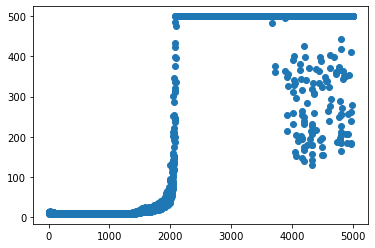

In [171]:
plt.scatter(np.array(range(len(episode_steps_rs))), episode_steps_rs)

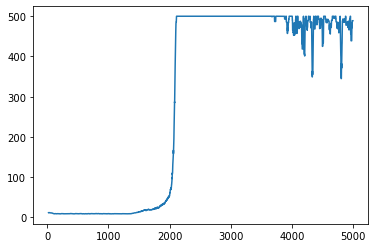

In [172]:
import pandas as pd
s1 = pd.Series(episode_steps_rs).rolling(20).mean()
s1.dropna(inplace=True)
plt.plot(s1)

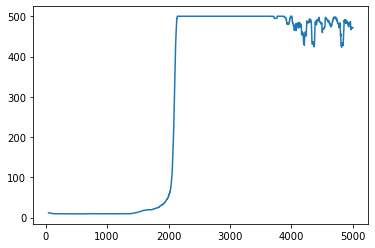

In [173]:
import pandas as pd
s2 = pd.Series(episode_steps_rs).rolling(50).mean()
s2.dropna(inplace=True)
plt.plot(s2)